In [1]:
# coding: utf-8
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from contextlib import contextmanager
import matplotlib.pyplot as plt
import pickle

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

path = '~/talkingdata/input/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

columns = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

print('start loading data')

with timer("Loading done"):
    with open('train_add_features_v3.csv.pkl','rb') as f:
        x_train=pickle.load(f)

    with open('y.csv.pkl','rb') as f:
        y_train = pickle.load(f)

start loading data
[Loading done] done in 59 s


In [2]:
# x_train, x_val, y_train, y_val = train_test_split(train_df, y, train_size=0.9, random_state=0)
# del train_df, y
# gc.collect()

evals_results = {}
num_boost_round = 859
# early_stopping_rounds = 50

min_data_in_leaf = 100
# min_data_in_leaf = 50
max_bin = 127
bagging_fraction = 0.7
bagging_freq = 1 
feature_fraction = 0.9
bin_construct_sample_cnt = 100000
min_hessian = 0 
scale_pos_weight = 200
max_depth = -1

lgb_params = {
   'boosting_type': 'gbdt',
   'objective': 'binary',
   'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
   'nthread': 24,
   'verbose': 0,
   'metric': 'auc',
   'learning_rate': 0.05,
#    'learning_rate': 0.1,
   'max_depth': max_depth,  # -1 means no limit
   'num_leaves': 31,  # 2^max_depth - 1
   'min_child_samples': min_data_in_leaf,  # Minimum number of data need in a child(min_data_in_leaf)
   'max_bin': max_bin,  # Number of bucketed bin for feature values
   'bin_construct_sample_cnt': bin_construct_sample_cnt,
   # 'subsample_for_bin': 20000,  # Number of samples for constructing bin
   'bagging_fraction': bagging_fraction,  # subsample
   'bagging_freq': bagging_freq,  # subsample_freq
   'feature_fraction': feature_fraction,  # colsample_bytree
   'min_sum_hessian_in_leaf': min_hessian,  # min_child_weight
   'scale_pos_weight': scale_pos_weight
}

# gc.collect()

In [3]:
target = "is_attributed"
categorical = ['app','os','channel','hour','device']
predictors = list(set(x_train.columns)-set([target])-set(['click_time','ip','app_by_channel_countuniq']))
# print(predictors)

print("preparing validation datasets")

xgtrain = lgb.Dataset(x_train[predictors].values,
                      label=y_train,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del x_train
del y_train
gc.collect()

# xgvalid = lgb.Dataset(x_val[predictors].values,
#                       label=y_val,
#                       feature_name=predictors,
#                       categorical_feature=categorical
#                       )

# del x_val
# del y_val
# gc.collect()

preparing validation datasets


37

In [4]:
print('start learning')

with timer("Learning done"):
    booster = lgb.train(
         lgb_params, 
         xgtrain,
         evals_result=evals_results, 
         num_boost_round=num_boost_round,
         verbose_eval=1
    )

    del xgtrain
    gc.collect()

start learning


/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[Learning done] done in 3895 s

Model Info:
n_estimators: 0


KeyError: 'valid'

In [5]:
# n_estimators = booster.best_iteration
# metrics = 'auc'

# print('\nModel Info:')
# print('n_estimators:', n_estimators)
# print(metrics+':', evals_results['valid'][metrics][n_estimators-1])


Model Info:
n_estimators: 0


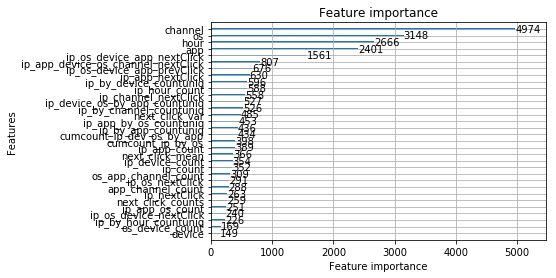

In [6]:
ax = lgb.plot_importance(booster, max_num_features=100)
plt.show()

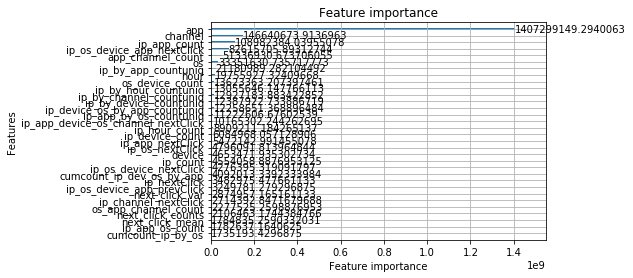

In [7]:
ax = lgb.plot_importance(booster, importance_type='gain')
plt.show()

In [8]:
plt.savefig('0507-1-3imp.png', dpi=600, bbox_inches='tight')

gc.collect()

6919

In [9]:
print('start loading data')

with timer("Loading done"):
    test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

    with open('testsup_add_features_v3.csv.pkl','rb') as f:
        testsup_df=pickle.load(f)

test_df['click_time']= pd.to_datetime(test_df['click_time'])
testsup_df['click_time']= pd.to_datetime(testsup_df['click_time'])

gc.collect()

print("Predicting the submission data...")

testsup_df['is_attributed'] = booster.predict(testsup_df[predictors], num_iteration=booster.best_iteration)

print('projecting prediction onto test')

join_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time']
all_cols = join_cols + ['is_attributed']

test_df = test_df.merge(testsup_df[all_cols], how='left', on=join_cols)

test_df = test_df.drop_duplicates(subset=['click_id'])

print("Writing the submission data into a csv file...")

test_df[['click_id', 'is_attributed']].to_csv('0507-1-3.csv', index=False)

print("All done...")

start loading data
[Loading done] done in 27 s
Predicting the submission data...
projecting prediction onto test
Writing the submission data into a csv file...
All done...


In [10]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time,is_attributed
0,0,5744,9,1,3,107,2017-11-10 04:00:00,0.134489
1,1,119901,9,1,3,466,2017-11-10 04:00:00,0.011621
2,2,72287,21,1,19,128,2017-11-10 04:00:00,0.001220
3,3,78477,15,1,13,111,2017-11-10 04:00:00,0.029109
4,4,123080,12,1,13,328,2017-11-10 04:00:00,0.014299
